<a href="https://colab.research.google.com/github/jwgdmkj/jupiterColab/blob/master/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# https://hansonminlearning.tistory.com/32
# https://m.blog.naver.com/hschoi237/221979636871 - 나중에 코랩 욜로 할거
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8 MB 27 kB/s 
     |████████████████████████████████| 3.8 MB 22.2 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 448 kB 46.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=9fe9652b67a802821cde7fc2e0c5736f0492c7ec3c39ef663225b22571668dbe
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

 TF-Hub module 가져오기

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

이미지 다운로드/도식화를 위한 라이브러리 가져오기

In [3]:
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

 이미지 상에 그리기 모듈 가져오기

In [4]:
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

디텍션에 걸리는 시간을 측정

In [5]:
import time

텐서플로우 버젼 확인

In [6]:
print(tf.__version__)

2.8.0


사용가능 GPU 확인

In [7]:
print("사용가능한 GPU : %s" % tf.test.gpu_device_name())
#print(tf.test.gpu_device_name())

사용가능한 GPU : /device:GPU:0


이미지 도식화 함수, 다운로드한 이미지 후처리

In [8]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

### 모듈 적용하기
▶ 웹상에서 있는 이미지 url을 통해 다운로드

Image downloaded to /tmp/tmpggd8il65.jpg.


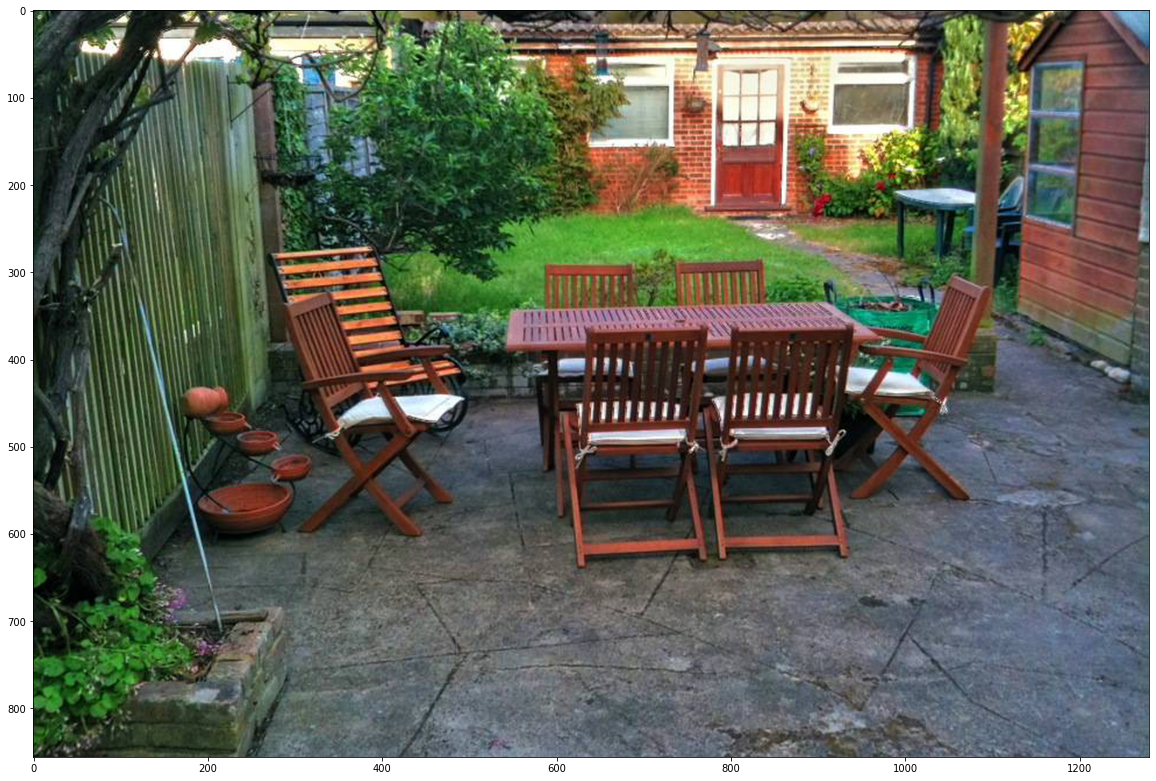

In [9]:
image_url = "https://farm1.staticflickr.com/4032/4653948754_c0d768086b_o.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

▶ 웹상에서 받은 이미지 디텍션 실행

FasterRCNN+InceptionResNet V2: 정확도 높음;
ssd+mobilenet V2: 속도 빠름, 상대적으로 낮은 정확도. 

In [10]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


▶ 디텍션 결과 출력

Found 100 objects.
Inference time:  45.881067991256714


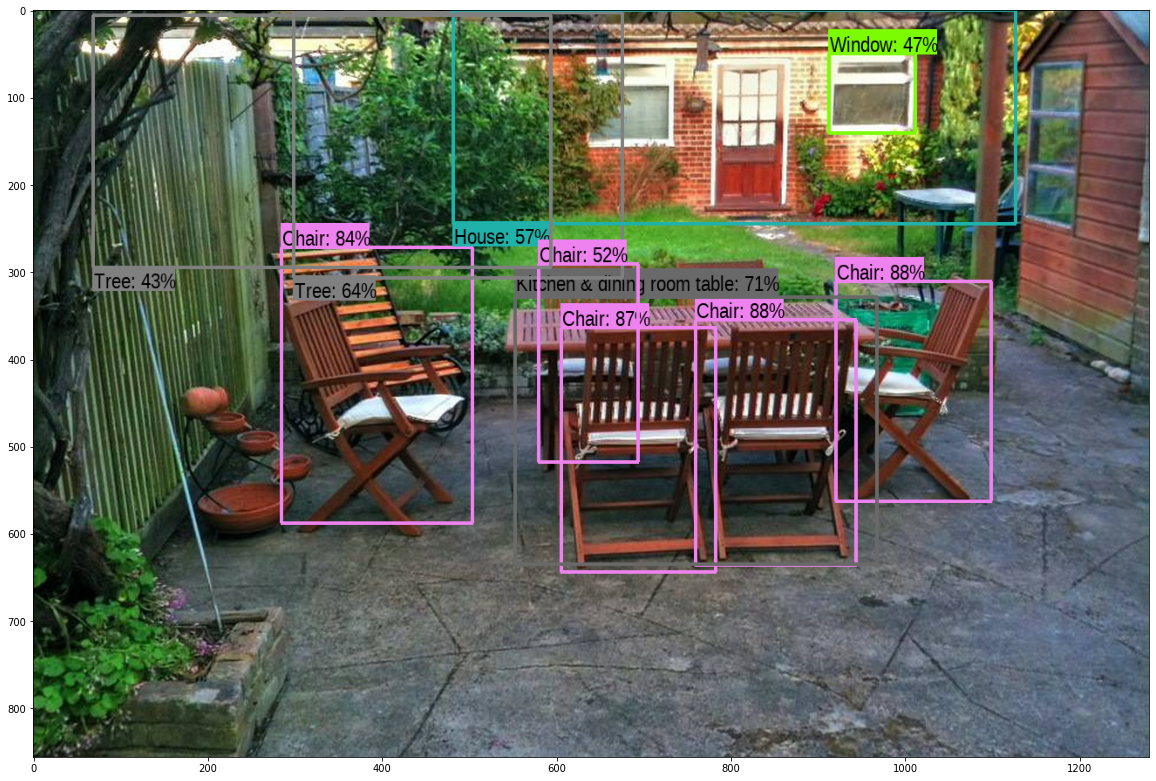

In [11]:
run_detector(detector, downloaded_image_path)

더 많은 이미지 디텍션하기
▶ 웹상에 있는 여러개 다른 이미지들을 디텍션하기 

Image downloaded to /tmp/tmplt1cpt6i.jpg.
Found 100 objects.
Inference time:  4.980729103088379
Inference time:
Image downloaded to /tmp/tmpghtgvfwm.jpg.
Found 100 objects.
Inference time:  2.7159385681152344
Inference time:
Image downloaded to /tmp/tmpboiiffjo.jpg.
Found 100 objects.
Inference time:  2.686488151550293
Inference time:


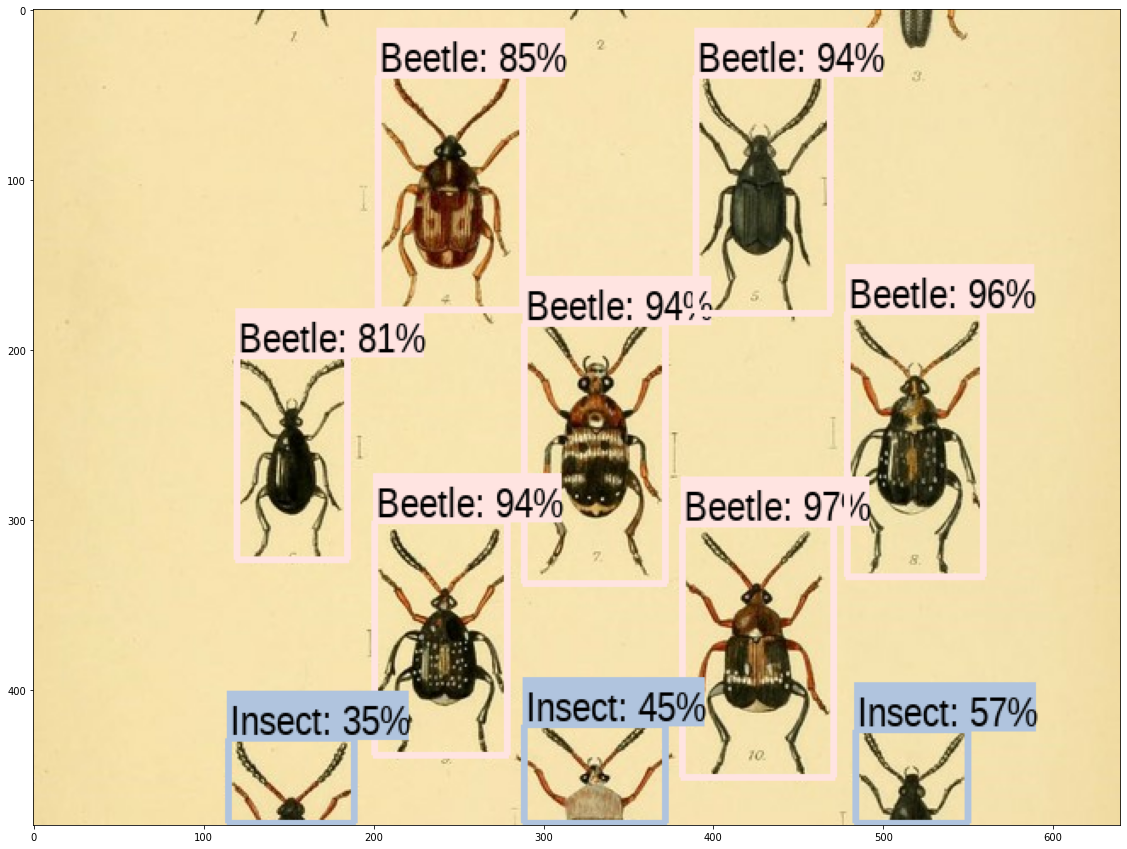

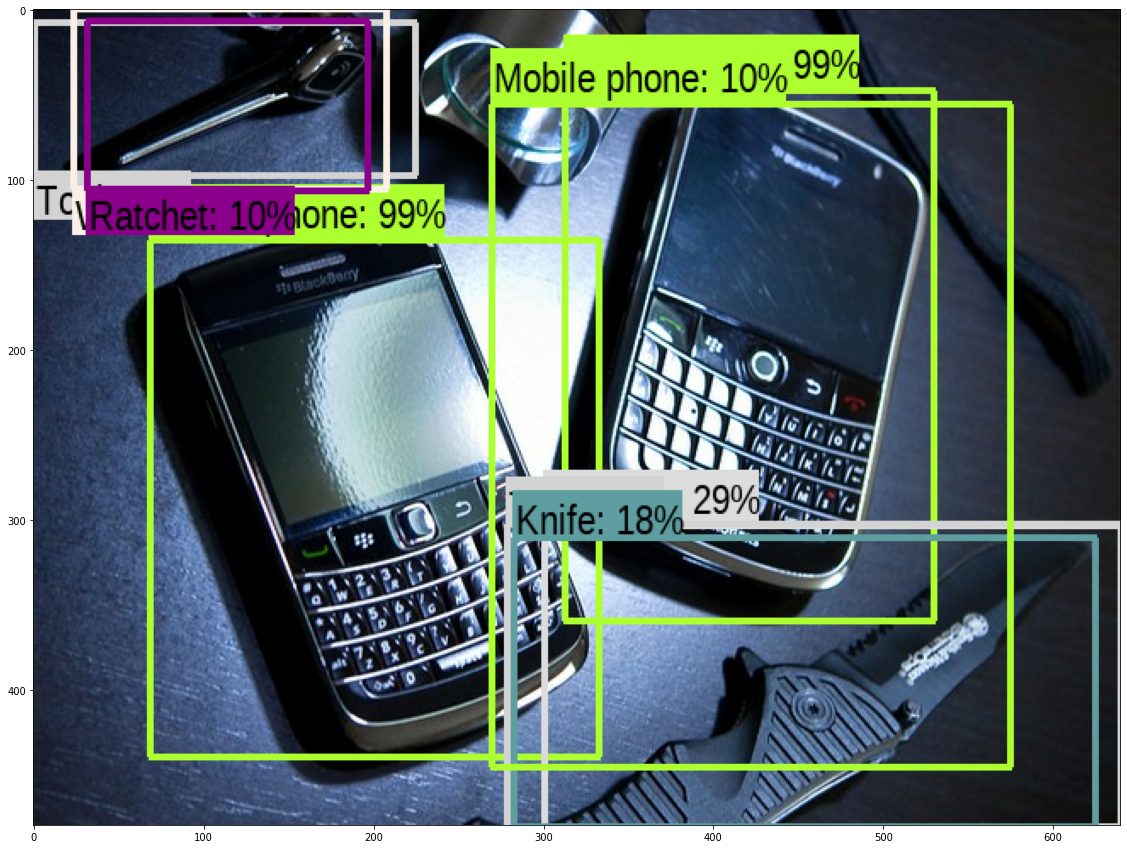

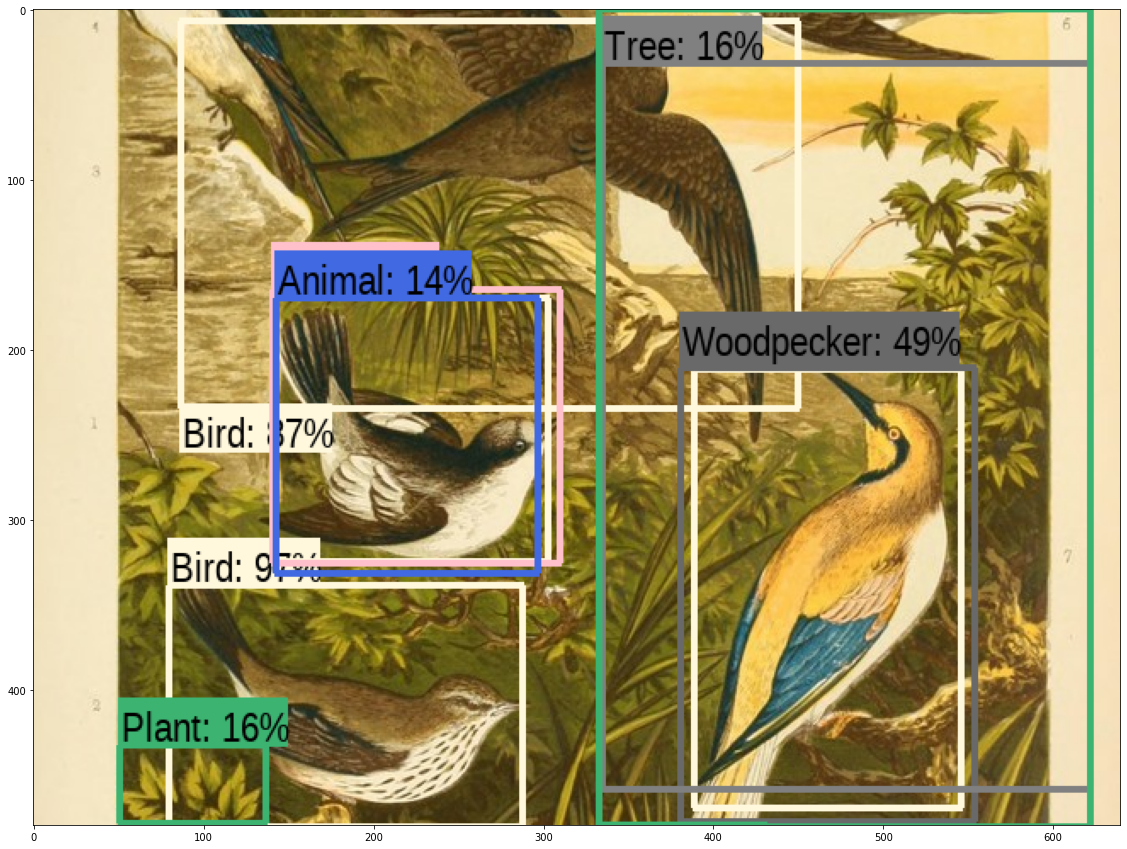

In [12]:
image_urls = ["https://farm7.staticflickr.com/8092/8592917784_4759d3088b_o.jpg",
              "https://farm6.staticflickr.com/2598/4138342721_06f6e177f3_o.jpg",
              "https://c4.staticflickr.com/9/8322/8053836633_6dc507f090_o.jpg"]

for image_url in image_urls:
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:")